### pktファイルからsqlite3データベースを作成してみる

#### 準備

In [153]:
import subprocess
from subprocess import PIPE

def shell(command):
#    print(command)
    proc = subprocess.run(command, shell=True, stdout=PIPE, stderr=PIPE, text=True)
    return proc.stdout, proc.stderr

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
import sqlite3

#### 登録nameの選択

In [164]:
#### 
startDateTime = datetime.datetime(year=2021, month=1, day=1)
durationInDay = 365 * 3 + 165

#startDateTime = datetime.datetime(year=2023, month=2, day=12)
#durationInDay = 10

type = 'L' # 'E' 'L' 'S'
devName = 'WMON'

type = 'E'
devName = 'MCU'

isVerbose = True   # show text output
dbName = 'tscLog.db'
####

df = pd.read_csv('dump-tsc-loghsc.csv', low_memory=False)
data = df.values

indexName = 1
indexType = 3
indexDev = 24

names = []
for d in data:
    if d[indexDev] == devName and d[indexType] == type:
        names.append(d[indexName])

if isVerbose:
    print(len(names), 'found')


310 found


In [165]:
def nextInputFilePath(inputFilePath):
    type = inputFilePath[15:16]
    year = int(inputFilePath[17:21])
    month = int(inputFilePath[21:23])
    day = int(inputFilePath[23:25])
    hour = int(inputFilePath[26:28])

    if hour == 8:
        hour = 17
        return f"/stars/{year}/TSC{type}-{year}{month:02d}{day:02d}-{hour:02d}.pkt"
    else:
        hour = 8
        _dateTime = datetime.datetime(year, month, day, hour, 0, 0) + datetime.timedelta(days=1)
        return f"/stars/{_dateTime.year}/TSC{type}-{_dateTime.year}{_dateTime.month:02d}{_dateTime.day:02d}-{hour:02d}.pkt"

def extractOutputFilePath(lines):
    for line in lines:
        if line.find('creating') >= 0:
            return line[11:]
    return ""

def datetimeFromeFilePath(filePath):
    year = int(filePath[17:21])
    month = int(filePath[21:23])
    day = int(filePath[23:25])
    hour = int(filePath[26:28])
    return datetime.datetime(year, month, day, hour, 0, 0)


#### データベースへの登録

In [166]:
if type == 'E':
    _type = 'V'
else:
    _type = type
    
extractor = "dump-tsc-log -a -z"

logDay = startDateTime  + datetime.timedelta(days=-1)
inputFilePath = f"/stars/{logDay.year}/TSC{_type}-{logDay.year}{logDay.month:02}{logDay.day:02}-17.pkt"

conn = sqlite3.connect(dbName)
cur = conn.cursor()

sqlCommandString = f'create table {devName}("index" integer, "#rxdate" string, "rxtime(HST)" string, "sec-from-00:00:00UTC" float,'
for name in names:
    sqlCommandString += f'\"{name}\" string, '
sqlCommandString += f'"datetime" datetime primary key)'
#cur.execute('create table WMON("index" integer, "#rxdate" string, "rxtime(HST)" string, "sec-from-00:00:00UTC" float, "Weather Temperature" string, "datetime" datetime primary key)')
cur.execute(sqlCommandString)

for i in range(durationInDay*2):
    if not os.path.exists(inputFilePath):
        print(f"{inputFilePath} not exist")
        inputFilePath = nextInputFilePath(inputFilePath)
        continue

    extractNames = f''
    for name in names:
        extractNames += f'-e \"{name}\" '

    (_, outputText) = shell(f'{extractor} {extractNames} {inputFilePath}')

    outputFilePath = extractOutputFilePath(outputText.split('\n'))
    if not os.path.exists(outputFilePath):
        print(f"{outputFilePath} not exist {outputText}")
        inputFilePath = nextInputFilePath(inputFilePath)
        continue

    df = pd.read_table(outputFilePath)
    df['datetime']= pd.to_datetime(df['#rxdate'] + ' ' + df['rxtime(HST)'])
    inputFileStartDatetime = datetimeFromeFilePath(inputFilePath)

    df = df.drop(index=[0]) # because the first row is a duplication of the last row in the previous data set
    df = df[df['sec-from-00:00:00UTC'] > 0] # because some contamination exist
    df = df[df['datetime'] > inputFileStartDatetime] # because weird contamination exist

    df = df.drop_duplicates(subset=['datetime'])
    df.to_sql(devName, conn, if_exists='append')

    os.remove(outputFilePath)
    
    inputFilePath = nextInputFilePath(inputFilePath)

cur.close()
conn.close()

/stars/2020/TSCV-20201231-17.pkt not exist
/stars/2021/TSCV-20210705-17.pkt not exist
/stars/2021/TSCV-20210719-17.pkt not exist
/stars/2021/TSCV-20210720-08.pkt not exist
/stars/2021/TSCV-20210720-17.pkt not exist
/stars/2021/TSCV-20210721-08.pkt not exist
/stars/2021/TSCV-20210721-17.pkt not exist
/stars/2021/TSCV-20210722-08.pkt not exist
/stars/2021/TSCV-20210722-17.pkt not exist
/stars/2021/TSCV-20210723-08.pkt not exist
/stars/2021/TSCV-20210723-17.pkt not exist
/stars/2021/TSCV-20210724-08.pkt not exist
/stars/2021/TSCV-20210724-17.pkt not exist
/stars/2021/TSCV-20210725-08.pkt not exist
/stars/2021/TSCV-20210725-17.pkt not exist
/stars/2021/TSCV-20210726-08.pkt not exist
/stars/2021/TSCV-20210726-17.pkt not exist
/stars/2021/TSCV-20210727-08.pkt not exist
/stars/2021/TSCV-20210727-17.pkt not exist
/stars/2021/TSCV-20210728-08.pkt not exist
/stars/2021/TSCV-20210728-17.pkt not exist
/stars/2021/TSCV-20210729-08.pkt not exist
/stars/2021/TSCV-20210729-17.pkt not exist
/stars/2021

#### データベースの読み出し

/home/satoshi/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


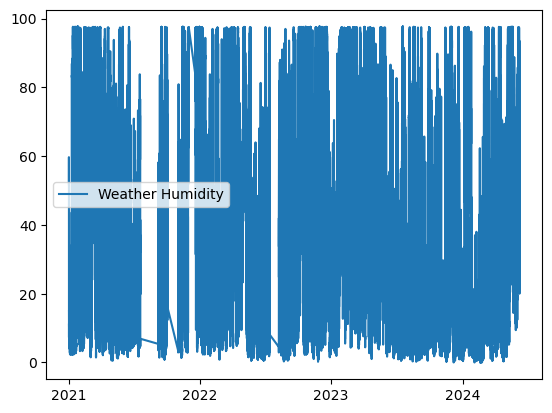

In [163]:
dbName = 'tscLog.db'
conn = sqlite3.connect(dbName)
cur = conn.cursor()

df = pd.read_sql(f"SELECT * FROM {devName} where datetime > '2021-01-01 17:00:00'and datetime < '2024-06-08 07:00:00'", conn)
#print(df.info())

df['datetime']= pd.to_datetime(df['#rxdate'] + ' ' + df['rxtime(HST)'])

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

name = 'Weather Humidity'

ax.plot(df['datetime'], df[name], label=name)
plt.legend()
plt.show()

cur.close()
conn.close()

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4662 entries, 0 to 4661
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 4662 non-null   int64         
 1   #rxdate               4662 non-null   object        
 2   rxtime(HST)           4662 non-null   object        
 3   sec-from-00:00:00UTC  4662 non-null   float64       
 4   Weather Temperature   4662 non-null   float64       
 5   datetime              4662 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 218.7+ KB


### classの定義

In [206]:
class RegisterData():
    def __init__(self, startDateTime, durationInDay, type, devName, dbName):
        self.startDateTime = startDateTime
        self.durationInDay = durationInDay
        self.type = type
        self.devName = devName
        self.dbName = dbName

        df = pd.read_csv('dump-tsc-loghsc.csv', low_memory=False)
        data = df.values

        indexName = 1
        indexType = 3
        indexDev = 24

        self.names = []
        for d in data:
            if d[indexDev] == devName and d[indexType] == self.type:
                self.names.append(d[indexName])
        print(len(self.names), 'found')
    

    def run(self):
        if self.type == 'E':
            _type = 'V'
            dataType = 'integer'
        else:
            _type = self.type
            dataType = 'float'
    
        extractor = "dump-tsc-log -a -z"

        logDay = self.startDateTime  + datetime.timedelta(days=-1)
        inputFilePath = f"/stars/{logDay.year}/TSC{_type}-{logDay.year}{logDay.month:02}{logDay.day:02}-17.pkt"

        conn = sqlite3.connect(self.dbName)
        cur = conn.cursor()

        sqlCommandString = f'create table {self.devName}_{self.type}("index" integer, "#rxdate" string, "rxtime(HST)" string, "sec-from-00:00:00UTC" float,'
        for name in self.names:
            sqlCommandString += f'\"{name}\" {dataType}, '
        sqlCommandString += f'"datetime" datetime primary key)'

        cur.execute(sqlCommandString)

        for i in range(self.durationInDay*2):
            if not os.path.exists(inputFilePath):
                print(f"{inputFilePath} not exist")
                inputFilePath = self.nextInputFilePath(inputFilePath)
                continue

            extractNames = f''
            for name in self.names:
                extractNames += f'-e \"{name}\" '

            (_, outputText) = shell(f'{extractor} {extractNames} {inputFilePath}')

            outputFilePath = self.extractOutputFilePath(outputText.split('\n'))
            if not os.path.exists(outputFilePath):
                print(f"{outputFilePath} not exist {outputText}")
                inputFilePath = self.nextInputFilePath(inputFilePath)
                continue
        
            df = pd.read_table(outputFilePath)
            df['datetime']= pd.to_datetime(df['#rxdate'] + ' ' + df['rxtime(HST)'])
            inputFileStartDatetime = self.datetimeFromeFilePath(inputFilePath)
        
            df = df.drop(index=[0]) # because the first row is a duplication of the last row in the previous data set
            df = df[df['sec-from-00:00:00UTC'] > 0] # because some contamination exist
            df = df[df['datetime'] > inputFileStartDatetime] # because weird contamination exist
        
            df = df.drop_duplicates(subset=['datetime'])
            df.to_sql(f'{self.devName}_{self.type}', conn, if_exists='append')
        
            os.remove(outputFilePath)
            
            inputFilePath = self.nextInputFilePath(inputFilePath)

        cur.close()
        conn.close()

    def nextInputFilePath(self, inputFilePath):
        type = inputFilePath[15:16]
        year = int(inputFilePath[17:21])
        month = int(inputFilePath[21:23])
        day = int(inputFilePath[23:25])
        hour = int(inputFilePath[26:28])
    
        if hour == 8:
            hour = 17
            return f"/stars/{year}/TSC{type}-{year}{month:02d}{day:02d}-{hour:02d}.pkt"
        else:
            hour = 8
            _dateTime = datetime.datetime(year, month, day, hour, 0, 0) + datetime.timedelta(days=1)
            return f"/stars/{_dateTime.year}/TSC{type}-{_dateTime.year}{_dateTime.month:02d}{_dateTime.day:02d}-{hour:02d}.pkt"
    
    def extractOutputFilePath(self, lines):
        for line in lines:
            if line.find('creating') >= 0:
                return line[11:]
        return ""
    
    def datetimeFromeFilePath(self, filePath):
        year = int(filePath[17:21])
        month = int(filePath[21:23])
        day = int(filePath[23:25])
        hour = int(filePath[26:28])
        return datetime.datetime(year, month, day, hour, 0, 0)



In [211]:
registerData = RegisterData(datetime.datetime(year=2021, month=1, day=1), 365 * 3 + 165, 'L', 'WMON', 'tscLog.db')
registerData.run()

8 found
/stars/2020/TSCL-20201231-17.pkt not exist
/stars/2021/TSCL_20210101-08.pkt not exist
/stars/2021/TSCL_20210102-08.pkt not exist
/stars/2021/TSCL_20210103-08.pkt not exist
/stars/2021/TSCL_20210104-08.pkt not exist
/stars/2021/TSCL_20210105-08.pkt not exist
/stars/2021/TSCL_20210106-08.pkt not exist
/stars/2021/TSCL_20210107-08.pkt not exist
/stars/2021/TSCL_20210108-08.pkt not exist
/stars/2021/TSCL_20210109-08.pkt not exist
/stars/2021/TSCL_20210110-08.pkt not exist
/stars/2021/TSCL_20210111-08.pkt not exist
/stars/2021/TSCL_20210112-08.pkt not exist
/stars/2021/TSCL_20210113-08.pkt not exist
/stars/2021/TSCL_20210114-08.pkt not exist
/stars/2021/TSCL_20210115-08.pkt not exist
/stars/2021/TSCL_20210116-08.pkt not exist
/stars/2021/TSCL_20210117-08.pkt not exist
/stars/2021/TSCL_20210118-08.pkt not exist
/stars/2021/TSCL_20210119-08.pkt not exist
/stars/2021/TSCL_20210120-08.pkt not exist
/stars/2021/TSCL_20210121-08.pkt not exist
/stars/2021/TSCL_20210122-08.pkt not exist
/st

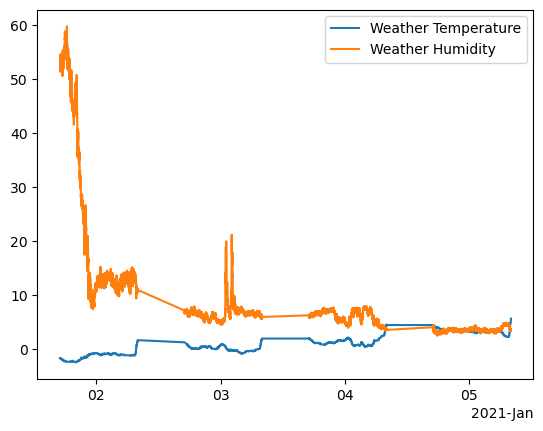

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35786 entries, 0 to 35785
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   index                         35786 non-null  int64         
 1   #rxdate                       35786 non-null  object        
 2   rxtime(HST)                   35786 non-null  object        
 3   sec-from-00:00:00UTC          35786 non-null  float64       
 4   Weather Wind Direction(AVG)   35786 non-null  float64       
 5   Weather Wind Velocity(AVG)    35786 non-null  float64       
 6   Weather Wind Direction(Max.)  35786 non-null  float64       
 7   Weather Wind Velocity(Max.)   35786 non-null  float64       
 8   Weather Temperature           35786 non-null  float64       
 9   Weather Humidity              35786 non-null  float64       
 10  Weather Accumulated RainFall  35786 non-null  float64       
 11  Weather Atmospheric Pressure

In [209]:
devName = 'WMON_L'
dbName = 'test.db'

names = ['Weather Temperature', 'Weather Humidity']
#names = ['Weather Humidity']

conn = sqlite3.connect(dbName)
cur = conn.cursor()

items = f'\"#rxdate\", \"rxtime(HST)\"'
for name in names:
    items += f', \"{name}\"'

df = pd.read_sql(f"SELECT * FROM {devName} where datetime > '2021-01-01 17:00:00'and datetime < '2024-09-23 06:00:00'", conn)
#print(df.info())

df['datetime']= pd.to_datetime(df['#rxdate'] + ' ' + df['rxtime(HST)'])

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)


for name in names:
    ax.plot(df['datetime'], df[name], label=name)
    
plt.legend()
plt.show()

cur.close()
conn.close()
print(df.info())